In [21]:
def Runmodel_Getcriticalvolume(minerals, modal_mineralogy, csds_means, csds_stds, deviation, optlearnvalue):
    optiprv = 1e9
    lower_bound =  modal_mineralogy-(deviation*modal_mineralogy)
    upper_bound =  modal_mineralogy+(deviation*modal_mineralogy)
    counter = 0
    highest_false = 0
    lowest_true = 1e9
    par_rock_new = (lowest_true + highest_false)/2
    while counter != 15: 
        model = SedGen(minerals, par_rock_new, modal_mineralogy, csds_means, csds_stds, learning_rate = optlearnvalue, discretization_init = False)
        simmineralogy = model.simulated_volume / par_rock_new
        proposition1 = simmineralogy >= lower_bound
        proposition2 = simmineralogy <= upper_bound
        print(par_rock_new)
        if np.all(proposition1 == True) and np.all(proposition2 == True):
            lowest_true = par_rock_new
            par_rock_new = (highest_false + lowest_true)/2
            counter += 1
            print("yes", simmineralogy, modal_mineralogy)
        else: 
            highest_false = par_rock_new
            par_rock_new = (highest_false + lowest_true)/2
            counter += 1
            print("No", simmineralogy, modal_mineralogy)
    return par_rock_new

In [22]:
import numpy as np
import numba as nb
from numba.typed import List
import pandas as pd
import itertools
from operator import itemgetter
import gc

from scipy.stats import norm, lognorm, truncnorm
import matplotlib.pyplot as plt
import seaborn as sns

from collections import Counter, deque
from sys import getsizeof

In [23]:
from sedgen.initialization import SedGen
from sedgen import initialization as ini
from sedgen import general as gen
from sedgen import preprocessing


In [24]:
from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = "all"

In [25]:
# Load jupyter extension to reload packages before executing user code.
# https://ipython.readthedocs.io/en/stable/config/extensions/autoreload.html
%load_ext autoreload
# Reload all packages (except those excluded by %aimport) every time 
# before executing the Python code typed.
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [26]:
minerals = ["Q", "P", "K", "B", "O", "A"]

modal_mineralogy = np.array([[0.16331256, 0.46387757, 0.12683457, 0.05758711, 0.01078412, 0.17760407],   # AZ
                             [0.27453254, 0.40124204, 0.24993859, 0.02509231, 0.00454988, 0.04464465],   # CA-EW
                             [0.30591989, 0.38159713, 0.26209888, 0.0188256 , 0.00799247, 0.02356603],   # CA-NS
                             [0.19781274, 0.41766034, 0.16121575, 0.06478527, 0.00894429, 0.14958161],   # GR
                             [0.25983144, 0.46392506, 0.15827298, 0.04370113, 0.00689158, 0.06737782],   # MT
                             [0.22419158, 0.48490082, 0.05641885, 0.11571367, 0.00000001, 0.11877509]])

csds_AZ_means = np.array([0.120, 0.174, 0.112, 0.155, 0.066, 0.079])
csds_AZ_stds = np.array([0.359, 0.356, 0.455, 0.399, 0.328, 0.452])

csds_CA_EW_means = np.array([0.247, 0.333, 0.292, 0.212, 0.090, 0.127])
csds_CA_EW_stds = np.array([0.986, 0.640, 0.497, 0.889, 0.275, 0.502])

csds_CA_NS_means = np.array([0.309, 0.330, 0.244, 0.223, 0.120, 0.122])
csds_CA_NS_stds = np.array([0.823, 0.683, 0.817, 0.819, 0.554, 0.782])

csds_GR_means = np.array([0.244, 0.269, 0.222, 0.251, 0.059, 0.107])
csds_GR_stds = np.array([0.312, 0.450, 0.444, 0.262, 0.378, 0.313])

csds_MT_means = np.array([0.220, 0.227, 0.160, 0.153, 0.078, 0.075])
csds_MT_stds = np.array([0.472, 0.415, 0.344, 0.363, 0.315, 0.599])

csds_WA_means = np.array([0.342, 0.385, 0.241, 0.481, 0.001, 0.130])
csds_WA_stds = np.array([0.542, 0.478, 0.386, 0.467, 0.001, 0.494])




In [27]:
critical_volume_AZ = Runmodel_Getcriticalvolume(minerals, modal_mineralogy[0], csds_AZ_means, csds_AZ_stds, deviation = 0.025, optlearnvalue = 150)
critical_volume_CA_EW = Runmodel_Getcriticalvolume(minerals, modal_mineralogy[1], csds_CA_EW_means, csds_CA_EW_stds, deviation = 0.025, optlearnvalue = 10000)
critical_volume_CA_NS = Runmodel_Getcriticalvolume(minerals, modal_mineralogy[2], csds_CA_NS_means, csds_CA_NS_stds, deviation = 0.025, optlearnvalue = 10000)
critical_volume_GR = Runmodel_Getcriticalvolume(minerals, modal_mineralogy[3], csds_GR_means, csds_GR_stds, deviation = 0.025, optlearnvalue = 150)
critical_volume_MT = Runmodel_Getcriticalvolume(minerals, modal_mineralogy[4], csds_MT_means, csds_MT_stds, deviation = 0.025, optlearnvalue = 200)
critical_volume_WA = Runmodel_Getcriticalvolume(minerals, modal_mineralogy[5], csds_WA_means, csds_WA_stds, deviation = 0.025, optlearnvalue = 10000)


---SedGen model initialization started---

Initializing modal mineralogy...
Initializing csds...
Initializing bins...
Simulating mineral occurences... |Q|P|K|B|O|A|
Initializing interfaces... |Q|P|K|B|O|A|
Counting interfaces...
Correcting interface arrays for consistency...
too much Q 5
too few P -4
too few K -1
too much B 1
too much O 1
too few A -2
Initializing crystal size array... |Q|P|K|B|O|A|
Initializing inter-crystal breakage probability arrays...
Initializing model evolution arrays...

---SedGen model initialization finished succesfully---
500000000.0
yes [0.16331306 0.46387906 0.12684948 0.05758856 0.01078492 0.17760459] [0.16331256 0.46387757 0.12683457 0.05758711 0.01078412 0.17760407]
---SedGen model initialization started---

Initializing modal mineralogy...
Initializing csds...
Initializing bins...
Simulating mineral occurences... |Q|P|K|B|O|A|
Initializing interfaces... |Q|P|K|B|O|A|
Counting interfaces...
Correcting interface arrays for consistency...
too much Q 2
too

In [18]:
print(critical_volume_AZ,critical_volume_CA_EW,critical_volume_CA_NS,critical_volume_GR,critical_volume_MT,critical_volume_WA)


57693481.4453125 271743774.4140625 504928588.8671875 61447143.5546875 499984741.2109375 82595825.1953125


In [19]:
weightedmeanAZ = np.sum(modal_mineralogy[0]*csds_AZ_means)
weightedmeanCA_EW = np.sum(modal_mineralogy[1]*csds_CA_EW_means)
weightedmeanCA_NS = np.sum(modal_mineralogy[2]*csds_CA_NS_means)
weightedmeanGR = np.sum(modal_mineralogy[3]*csds_GR_means)
weightedmeanMT = np.sum(modal_mineralogy[4]*csds_MT_means)
weightedmeanWA = np.sum(modal_mineralogy[5]*csds_WA_means)

Text(0, 0.5, 'weighted mean grainsizes (mm)')

Text(0.5, 0, 'critical volume threshold (mm^3)')

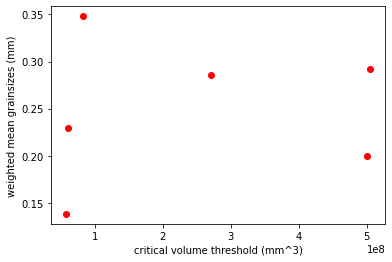

In [20]:
yaxis = np.array([weightedmeanAZ,weightedmeanCA_EW,weightedmeanCA_NS,weightedmeanGR,weightedmeanMT,weightedmeanWA])
xaxis = np.array([critical_volume_AZ, critical_volume_CA_EW, critical_volume_CA_NS, critical_volume_GR, critical_volume_MT, critical_volume_WA])
plt.ylabel('weighted mean grainsizes (mm)')
plt.xlabel('critical volume threshold (mm^3)')
plt.plot(xaxis, yaxis, 'ro')